# **패션 이미지 기반 상품 카테고리 분류**

## **1) 목표**

- 패션 이미지 카테고리 자동 예측
  - 자동으로 분류할 패션 아이템 카테고리/속성을 정의
  - 안정적이고 효율적인 레이블링 수행을 지원
- 유사 상품 추천
  - 패션 이미지 간 유사도를 계산하여 유사한 상품 추천

## **2) 데이터 소개**

[kaggle | Fashion Product Images](https://www.kaggle.com/paramaggarwal/fashion-product-images-small)

### **데이터 구조**

데이터셋에 따른 항목과 해당 값은 아래 테이블과 같다.


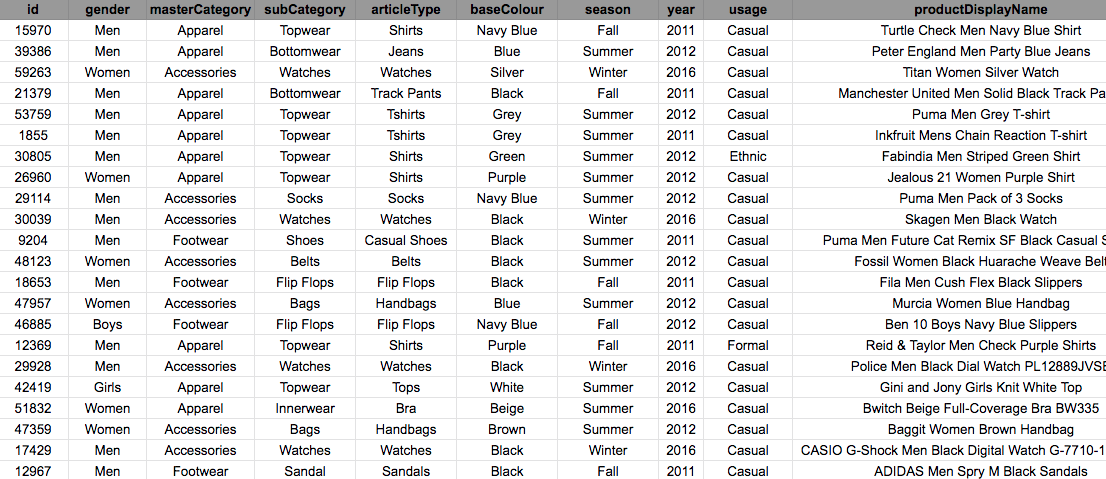

### **이미지**

총 12,000건 패션 이미지 데이터로 구성되어 있다.

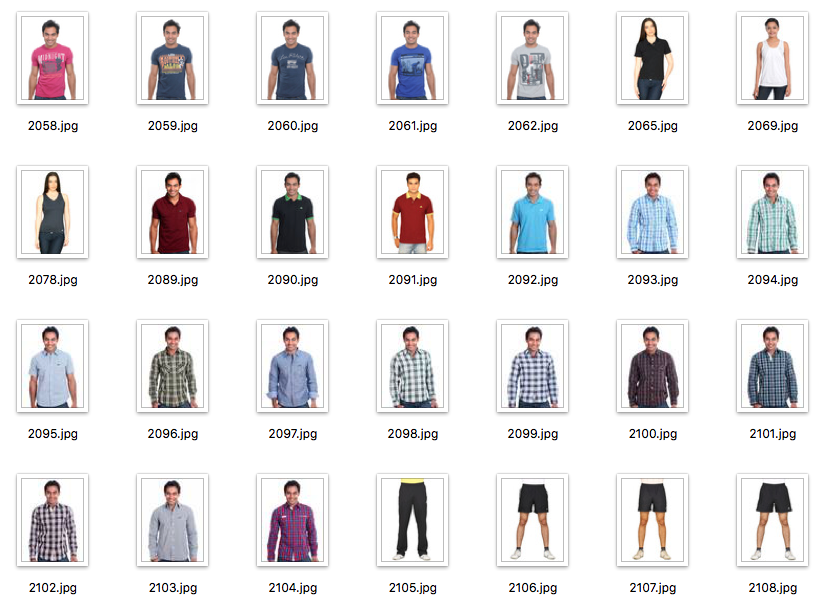

## **3) 가설**

아이템별(상의, 원피스, 신발) 이미지를 잘못 분류한다.

## **4) 모델 구축**

### **이미지 분류 모델**

In [1]:
!pip install swifter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras_preprocessing.image import ImageDataGenerator

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import swifter

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalMaxPooling2D

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import LabelEncoder

In [ ]:
# 데이터셋 불러오기
df = pd.read_csv('/content/drive/MyDrive/styles.csv', error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.sample(frac=1).reset_index(drop=True)
print(df.shape)
df.head(10)

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

(44424, 11)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,36720,Boys,Apparel,Topwear,Tshirts,Black,Summer,2012.0,Casual,Palm Tree Boys Printed Black T-Shirt,36720.jpg
1,2024,Men,Apparel,Topwear,Tshirts,Red,Fall,2010.0,Casual,ADIDAS Mens Fitted Red T-shirt,2024.jpg
2,55205,Women,Personal Care,Lips,Lipstick,Brown,Spring,2017.0,Casual,Lakme Lip Love Dark Desire Lipstick B122A,55205.jpg
3,12044,Men,Apparel,Bottomwear,Jeans,Blue,Fall,2011.0,Casual,Spykar Men Washed Blue Jeans,12044.jpg
4,46474,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Timex Men Black Dial Watch L506,46474.jpg
5,9441,Unisex,Accessories,Bags,Backpacks,Black,Spring,2013.0,Casual,Nike Unisex Hayward 25m B Black Backpacks,9441.jpg
6,51524,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Fastrack Men Black Dial Watch,51524.jpg
7,16155,Men,Footwear,Shoes,Formal Shoes,Brown,Fall,2011.0,Formal,Enroute Men Leather Brown Formal Shoes,16155.jpg
8,5176,Men,Apparel,Topwear,Tshirts,Black,Summer,2011.0,Casual,Marvel Men's Spiderman Zoom In Action Black T-...,5176.jpg
9,13063,Men,Accessories,Watches,Watches,Brown,Winter,2016.0,Casual,Fastrack Men Smooth Finish Strap Black Watches,13063.jpg


In [ ]:
# 타겟 레이블 확인
df['subCategory'].value_counts(normalize=True)

# # label 전처리
# encoder = LabelEncoder()
# result = encoder.fit_transform(df['subCategory'])
# df['subCategory'] = result

Topwear                     0.346704
Shoes                       0.165294
Bags                        0.068769
Bottomwear                  0.060643
Watches                     0.057221
Innerwear                   0.040699
Jewellery                   0.024289
Eyewear                     0.024154
Fragrance                   0.022758
Sandal                      0.021677
Wallets                     0.021002
Flip Flops                  0.020552
Belts                       0.018256
Socks                       0.015712
Lips                        0.011863
Dress                       0.010760
Loungewear and Nightwear    0.010580
Saree                       0.009612
Nails                       0.007406
Makeup                      0.006911
Headwear                    0.006596
Ties                        0.005808
Accessories                 0.002904
Scarves                     0.002656
Cufflinks                   0.002431
Apparel Set                 0.002386
Free Gifts                  0.002341
S

In [ ]:
# 이미지 전처리
image_generator = ImageDataGenerator(
    validation_split=0.2
)

training_generator = image_generator.flow_from_dataframe(
    dataframe=df,
    directory='/content/drive/MyDrive/images',
    x_col="image",
    y_col="subCategory",
    target_size=(96,96),
    batch_size=32,
    subset="training"
)

validation_generator = image_generator.flow_from_dataframe(
    dataframe=df,
    directory='/content/drive/MyDrive/images',
    x_col="image",
    y_col="subCategory",
    target_size=(96,96),
    batch_size=32,
    subset="validation"
)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 32424 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 9600 validated image filenames belonging to 31 classes.
Found 2400 validated image filenames belonging to 31 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 32424 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
# 모델 구축
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(31, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(training_generator, epochs=5, validation_data=(validation_generator))

Epoch 1/5
300/300 [==============================] - 1759s 6s/step - loss: 2.4215 - accuracy: 0.8002 - val_loss: 0.4781 - val_accuracy: 0.8913
Epoch 2/5
300/300 [==============================] - 13s 42ms/step - loss: 0.3806 - accuracy: 0.9074 - val_loss: 0.4207 - val_accuracy: 0.8992
Epoch 3/5
300/300 [==============================] - 12s 41ms/step - loss: 0.2424 - accuracy: 0.9367 - val_loss: 0.3814 - val_accuracy: 0.9142
Epoch 4/5
300/300 [==============================] - 13s 44ms/step - loss: 0.1621 - accuracy: 0.9513 - val_loss: 0.4176 - val_accuracy: 0.9217
Epoch 5/5
300/300 [==============================] - 12s 41ms/step - loss: 0.1464 - accuracy: 0.9568 - val_loss: 0.4182 - val_accuracy: 0.9217


In [ ]:
model.evaluate(validation_generator)

75/75 [==============================] - 3s 34ms/step - loss: 0.4182 - accuracy: 0.9217


[0.4182492196559906, 0.92166668176651]

-----

In [ ]:
# 모델 제작
model2 = Sequential()

model2.add(ResNet50(include_top = False, pooling = 'avg')) 
model2.add(Dense(31, activation = 'softmax'))

model2.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 31)                63519     
Total params: 23,651,231
Trainable params: 23,598,111
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model2.fit(training_generator, epochs=5, validation_data=(validation_generator))

Epoch 1/5
300/300 [==============================] - 26s 71ms/step - loss: 0.4725 - accuracy: 0.8870 - val_loss: 1.0176 - val_accuracy: 0.8600
Epoch 2/5
300/300 [==============================] - 21s 70ms/step - loss: 0.2030 - accuracy: 0.9436 - val_loss: 0.1637 - val_accuracy: 0.9546
Epoch 3/5
300/300 [==============================] - 21s 69ms/step - loss: 0.1198 - accuracy: 0.9643 - val_loss: 0.1897 - val_accuracy: 0.9408
Epoch 4/5
300/300 [==============================] - 21s 68ms/step - loss: 0.0892 - accuracy: 0.9714 - val_loss: 0.3725 - val_accuracy: 0.9342
Epoch 5/5
300/300 [==============================] - 21s 68ms/step - loss: 0.0829 - accuracy: 0.9739 - val_loss: 0.3724 - val_accuracy: 0.9000


In [ ]:
model2.evaluate(validation_generator)

75/75 [==============================] - 3s 36ms/step - loss: 0.3724 - accuracy: 0.9000


[0.37243902683258057, 0.8999999761581421]

---

In [ ]:
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (96, 96, 3))
base_model.trainable = False
model3 = tf.keras.Sequential([
    base_model,
    GlobalMaxPooling2D(),
    Dense(31, activation = 'softmax')
])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 31)                63519     
Total params: 23,651,231
Trainable params: 63,519
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model3.fit(training_generator, epochs=5, validation_data=(validation_generator))

Epoch 1/5
300/300 [==============================] - 17s 47ms/step - loss: 0.8790 - accuracy: 0.8698 - val_loss: 0.4048 - val_accuracy: 0.9250
Epoch 2/5
300/300 [==============================] - 13s 45ms/step - loss: 0.2351 - accuracy: 0.9433 - val_loss: 0.3732 - val_accuracy: 0.9300
Epoch 3/5
300/300 [==============================] - 13s 44ms/step - loss: 0.1595 - accuracy: 0.9581 - val_loss: 0.3531 - val_accuracy: 0.9354
Epoch 4/5
300/300 [==============================] - 13s 44ms/step - loss: 0.1235 - accuracy: 0.9684 - val_loss: 0.3887 - val_accuracy: 0.9279
Epoch 5/5
300/300 [==============================] - 13s 45ms/step - loss: 0.0819 - accuracy: 0.9774 - val_loss: 0.3426 - val_accuracy: 0.9388


In [ ]:
model3.evaluate(validation_generator)

75/75 [==============================] - 3s 36ms/step - loss: 0.3426 - accuracy: 0.9388


[0.34264642000198364, 0.9387500286102295]

---

### **유사도 측정을 통한 추천 모델**

In [4]:
df = pd.read_csv('/content/drive/MyDrive/styles_similarity.csv', error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.shape

(12000, 12)

In [5]:
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def img_path(img):
    return '/content/drive/MyDrive/images/'+img

def load_image(img):
    return cv2.imread(img_path(img))

In [6]:
# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (69, 69, 3))
base_model.trainable = False

# Add Layer Embedding
model4 = tf.keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [7]:
def get_embedding(model, img_name):
    img = image.load_img(img_path(img_name), target_size=(69, 69))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return model.predict(x).reshape(-1)

In [8]:
emb = get_embedding(model4, df.iloc[5].image)
emb.shape

(2048,)

[0.        0.        0.        ... 0.4536016 4.009802  3.5307875]


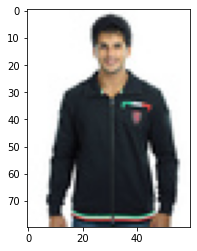

In [9]:
plt.imshow(cv2.cvtColor(load_image(df.iloc[5].image), cv2.COLOR_BGR2RGB))
print(emb)

In [11]:
map_embeddings = df['image'].swifter.apply(lambda img: get_embedding(model4, img))
df_embs = map_embeddings.apply(pd.Series)

print(df_embs.shape)
df_embs.head()

Pandas Apply:   0%|          | 0/12000 [00:00<?, ?it/s]

(12000, 2048)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.000000,4.882992,0.000000,2.546227,0.000000,11.505772,0.000000,0.000000,3.781673,1.213147,0.00000,0.000000,1.814074,0.000000,0.000000,0.0,0.0,0.000000,3.445967,0.000000,0.0,0.000000,0.0,0.185861,3.412513,1.904997,0.102228,0.000000,7.654498,0.000000,0.632625,1.847693,0.000000,0.000000,0.000000,2.166949,8.512493,0.745747,2.582845,0.978849,...,5.132286,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.389500,0.000000,2.109109,0.000000,0.000000,10.994735,0.0,0.449247,2.537401,15.202643,0.556358,9.117518,2.390574,0.000000,0.000000,0.096975,12.038284,0.0000,4.703230,0.000000,3.372225,3.455320,0.0,0.000000,0.000000,0.885977,0.023773,6.437772,0.000000,4.250127,5.092907
1,0.000000,11.324313,2.022874,0.000000,0.000000,13.411961,2.867108,0.000000,0.000000,0.701879,0.00000,0.000000,0.000000,0.000000,3.607923,0.0,0.0,0.000000,1.943594,0.000000,0.0,0.076005,0.0,0.000000,8.191848,1.512488,0.001327,0.000000,6.330029,0.000000,0.000000,0.000000,0.406008,0.000000,0.993109,1.694064,2.499875,0.000000,2.487662,0.663742,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.560521,0.000000,1.406939,7.884283,0.0,0.000000,1.689234,6.643930,2.731379,6.358367,0.000000,0.000000,0.000000,0.000000,13.537801,0.0000,3.371041,0.000000,1.936497,0.000000,0.0,1.097503,0.000000,0.000000,0.000000,3.928297,0.000000,0.000000,7.270278
2,0.810897,0.487000,0.000000,4.080239,0.810210,0.619694,0.000000,18.588808,16.434084,0.143069,0.00000,1.387598,1.669154,0.000000,4.178889,0.0,0.0,2.072477,0.000000,5.302438,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500690,0.000000,6.796335,3.817925,1.332933,9.074505,0.000000,0.000000,5.458675,0.197443,2.627378,...,2.993406,6.920607,0.000000,0.000000,0.000000,2.565960,0.0,0.0,0.000000,8.024105,0.000000,8.033447,3.469629,0.000000,1.066671,0.0,5.042254,0.000000,14.576221,3.034493,0.000000,0.000000,0.000000,0.000000,2.961902,0.000000,0.7353,1.809820,0.198676,0.000000,0.172847,0.0,0.000000,9.274383,0.554679,0.000000,3.069425,2.886358,1.535508,5.859603
3,0.000000,2.786283,0.000000,0.000000,5.454137,4.127724,9.123839,0.000000,0.000000,2.973217,1.57205,0.000000,0.000000,0.000000,9.002785,0.0,0.0,1.360674,0.193236,0.000000,0.0,0.000000,0.0,0.051119,0.028672,0.762558,0.000000,0.433239,0.445147,0.059338,0.000000,0.000000,1.498142,0.112465,8.898205,8.605099,3.984014,6.075659,0.000000,2.606743,...,2.446046,0.000000,4.423645,7.314048,0.000000,1.249005,0.0,0.0,0.000000,7.028481,0.167963,0.000000,0.292346,0.000000,7.925774,0.0,0.000000,0.000000,7.402994,3.628922,0.030880,0.000000,0.387279,2.298476,0.000000,6.994975,0.0000,0.000000,0.000000,3.583188,0.000000,0.0,2.583138,2.800825,1.320098,0.000000,18.721865,1.978873,7.399749,2.211358
4,0.000000,12.306199,0.000000,0.613469,5.026155,0.297824,2.663381,0.372909,0.000000,0.000000,0.00000,0.799646,0.000000,1.266517,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,4.989703,0.000000,3.723618,1.056562,0.006208,0.000000,0.000000,11.579530,0.741956,3.443766,7.200663,2.297911,2.134493,2.131621,0.000000,0.149485,...,2.722395,0.000000,2.020612,1.796344,1.596804,0.000000,0.0,0.0,1.115072,1.853638,0.000000,0.000000,3.183073,0.000000,2.737512,0.0,0.000000,1.521020,9.409822,0.000000,0.000000,0.065699,0.000000,13.369795,0.000000,14.535162,0.0000,0.000000,1.194370,9.510351,0.658986,0.0,1.359062,3.253173,1.923594,1.471919,0.000000,0.000000,5.390780,6.347136


In [12]:
# calculate distance matriz
cosine_sim = 1-pairwise_distances(df_embs, metric='cosine')
cosine_sim[:4, :4]

array([[1.        , 0.8108279 , 0.37832355, 0.45342708],
       [0.8108279 , 0.9999997 , 0.35898757, 0.48368782],
       [0.37832355, 0.35898757, 0.99999934, 0.38472617],
       [0.45342708, 0.48368782, 0.38472617, 1.        ]], dtype=float32)

In [13]:
indices = pd.Series(range(len(df)), index=df.index)
indices

# Function that get movie recommendations based on the cosine similarity score of movie genres
def get_recommender(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

get_recommender(2993, df, top_n = 5)

(Int64Index([3004, 2987, 4199, 2984, 1862], dtype='int64'),
 [0.8400407, 0.83507997, 0.82940376, 0.82376766, 0.82370317])

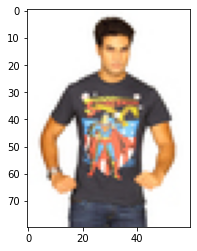

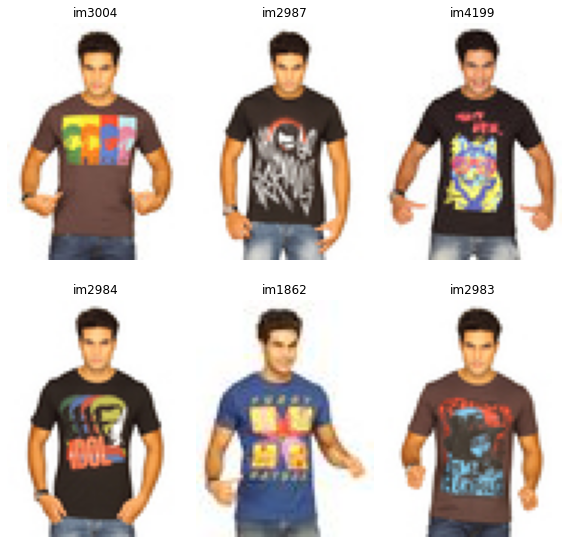

In [14]:
# 추천시스템 적용(1)
idx_ref = 2993

idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
plot_figures(figures, 2, 3)

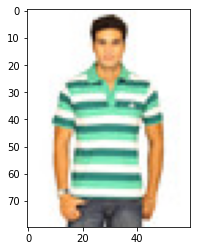

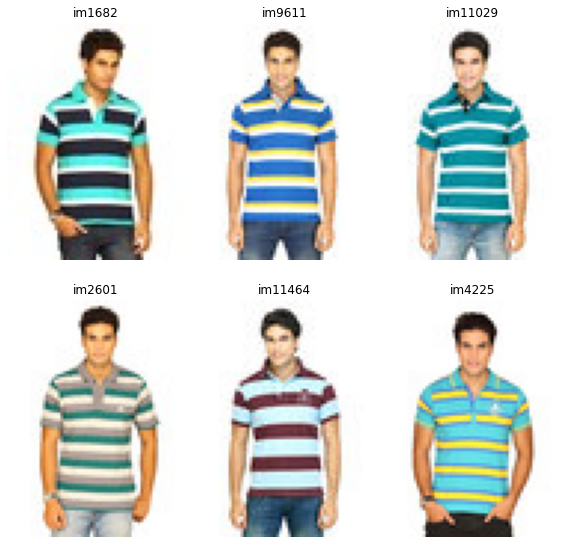

In [15]:
# 추천시스템 적용(2)
idx_ref = 2600

idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
plot_figures(figures, 2, 3)